In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
import numpy as np

from sklearn.pipeline import Pipeline

In [376]:
path = '../../CrawlData/all_data/final_data_movie.csv'
data = pd.read_csv(path)
data = data[['Title','Genre','review_film']]

In [377]:
#! drop all null column in Genre
data=data.dropna().reset_index(drop=True)

In [378]:
#! genre only get 1 type:
for i in range(len(data['Genre'])):
        #print(g)
        if "," in data['Genre'][i]:
            g = data['Genre'][i].split(", ")[1]
            #g = g.split(", ")[1]
            data.loc[i,'Genre'] = g
        else:
            continue

In [379]:
data.head(3)

,Title,Genre,review_film
0,Frieren: Beyond Journey's End,Drama,During their decade-long quest to defeat the D...
1,Fullmetal Alchemist: Brotherhood,Adventure,After a horrific alchemy experiment goes wrong...
2,Steins;Gate,Sci-Fi,Eccentric scientist Rintarou Okabe has a never...


In [380]:
print(data.isnull().sum())

Title          0
Genre          0
review_film    0
dtype: int64


In [381]:
X_train, X_test, Y_train, Y_test = train_test_split(data,data['Genre'],random_state=42,test_size=0.2)

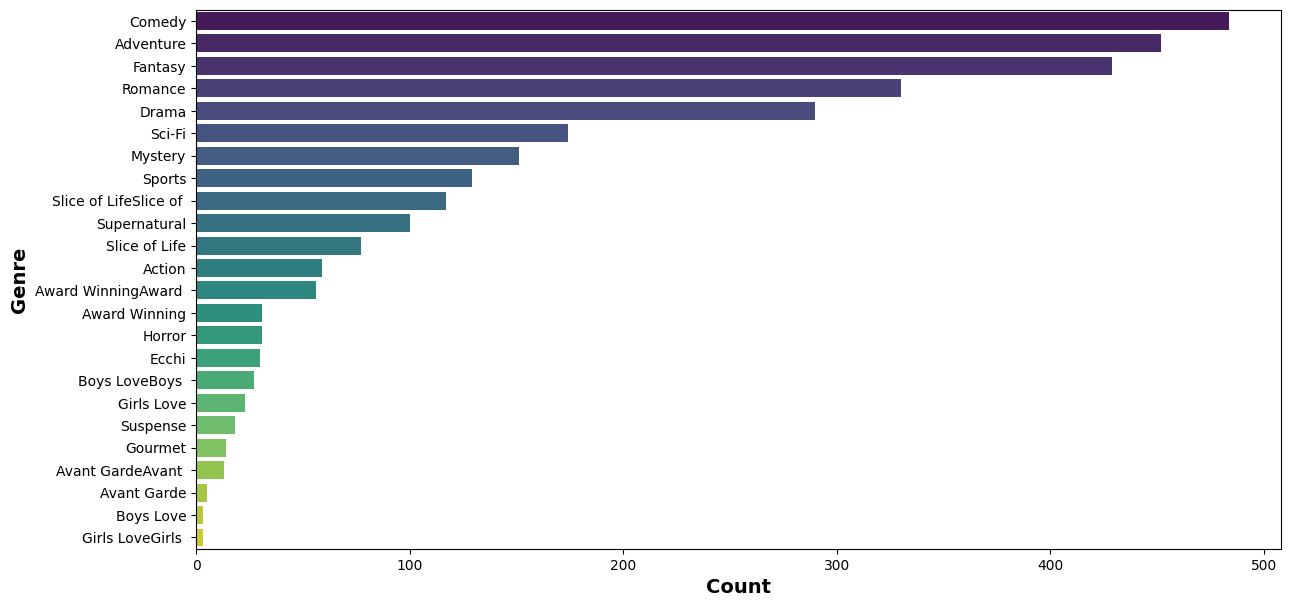

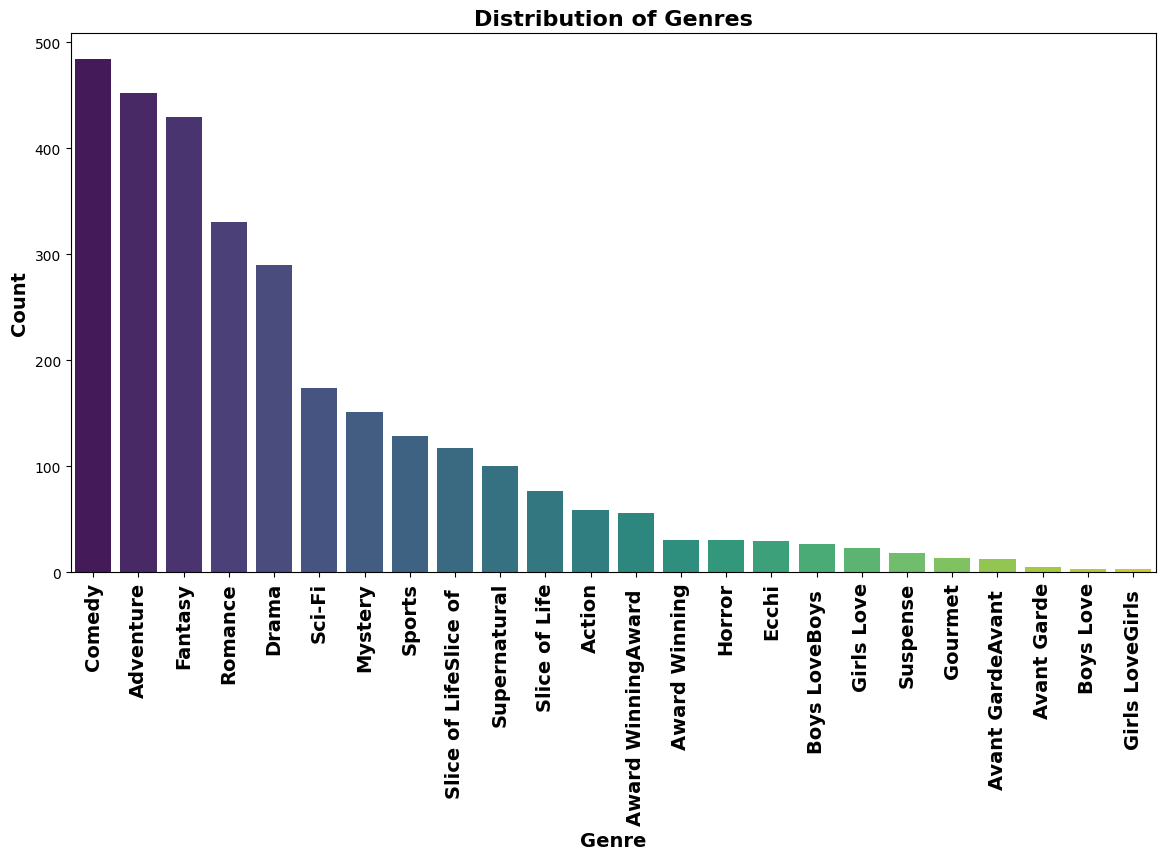

In [382]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=X_train, y='Genre', order=X_train['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = X_train['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [383]:
#! Cải thiện 1: Clean text của mình khác với cleantext của người ta. Nếu dùng cleantext của mình thì vẫn sử dụng tf-idf của người ta

In [384]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    #! to lower case:
    text = text.lower()
    #! delete all strange character
    text = re.sub('<[^<]+?>',' ',text)
    #! remove punctuation:
    text = text.translate(str.maketrans('', '', string.punctuation))
    #! keep only character:
    text = re.sub(r"[^a-zA-Z+']",' ',text)
    #! keep word with length < len(tatsunokoproduction)
    text = re.sub(r"\b\w{1,len(tatsunokoproduction)}\b",' ',text)
    #! stemming word:
    text = stemmer.stem(text)
    #! remove all stopword:
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    #! remove stopword
    words = nltk.word_tokenize(text)
    #print(words)
    text = "".join([i for i in words if i not in stopwords])
    
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
X_train['Text_cleaning'] = X_train['review_film'].apply(clean_text)
X_test['Text_cleaning'] = X_test['review_film'].apply(clean_text)

# X_train['Text_cleaning'] = X_train['review_film'].astype(str)
# X_test['Text_cleaning'] = X_test['review_film'].astype(str)
clean_text("<h1>She does her house works every day,!?</h1>")

'houseworkseveryday'

In [385]:
X_train['Text_cleaning']

3329    searcharakigenzogeorgekodamafindssmalltownkimu...
2980    onedayearthassaultedspacepirateorbusaimedplane...
1350    mikansakuranormalyearoldgirloptimisticenergeti...
3789    blackbloodsredbloodsvampireshumansdespitediffe...
246     followingsuccessqualifyingroundkansairegionalc...
                              ...                        
1130    fiveyearseventsdragonballmartialartsexpertgoku...
1294    tsurunesoundmadebowstringarrowreleasedsoundins...
860     wayhomeschoolyukarihayasakaapproachedweirdlook...
3507    gulliverboybornabilityusemagicforcedattendmagi...
3174    specialincludedkurokobasketfandischikarisasuba...
Name: Text_cleaning, Length: 3046, dtype: object

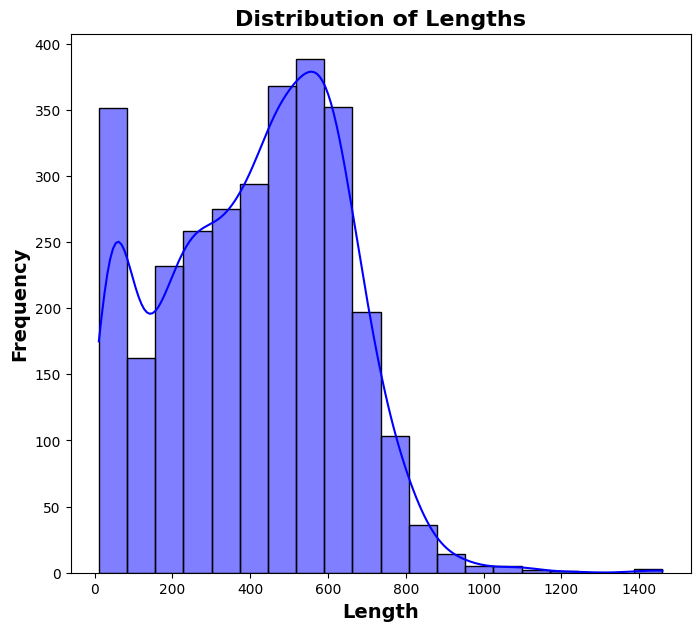

In [386]:

# Calculate the length of cleaned text
X_train['length_Text_cleaning'] = X_train['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=X_train, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

In [387]:
#! cải thiện 2: Sử dụng countVectorize. Nếu sử dụng thì sử dụng clean text của baseline

In [388]:
X_train['Text_cleaning']

3329    searcharakigenzogeorgekodamafindssmalltownkimu...
2980    onedayearthassaultedspacepirateorbusaimedplane...
1350    mikansakuranormalyearoldgirloptimisticenergeti...
3789    blackbloodsredbloodsvampireshumansdespitediffe...
246     followingsuccessqualifyingroundkansairegionalc...
                              ...                        
1130    fiveyearseventsdragonballmartialartsexpertgoku...
1294    tsurunesoundmadebowstringarrowreleasedsoundins...
860     wayhomeschoolyukarihayasakaapproachedweirdlook...
3507    gulliverboybornabilityusemagicforcedattendmagi...
3174    specialincludedkurokobasketfandischikarisasuba...
Name: Text_cleaning, Length: 3046, dtype: object

In [389]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_idf = tfidf_vectorizer.fit_transform(X_train['Text_cleaning'])

# Transform the test data
X_test_idf = tfidf_vectorizer.transform(X_test['Text_cleaning'])

In [390]:
#! link tham khao cac dung precision_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
#! https://stackoverflow.com/questions/45890328/sklearn-metrics-for-multiclass-classification
classifier = MultinomialNB()
classifier.fit(X_train_idf, Y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_test_idf)

# Evaluate the performance of the model
accuracy = accuracy_score(Y_test, y_pred)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(Y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(Y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(Y_test, y_pred,average='micro'))

Validation Accuracy: 0.18635170603674542
validation Precision:  0.18635170603674542
Validation Recall: 0.18635170603674542
Validation f1 score:  0.18635170603674542


In [391]:
from sklearn import svm
my_svm = svm.SVC(kernel='poly',gamma=3)
my_svm.fit(X_train_idf, Y_train)
pred = my_svm.predict(X_test_idf)
accuracy = accuracy_score(y_pred=pred, y_true=Y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(Y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(Y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(Y_test, y_pred,average='micro'))

Validation Accuracy: 0.18766404199475065
validation Precision:  0.18635170603674542
Validation Recall: 0.18635170603674542
Validation f1 score:  0.18635170603674542


In [392]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train_idf,Y_train)
pred = log.predict(X_test_idf)
accuracy = accuracy_score(y_pred=pred, y_true=Y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(Y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(Y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(Y_test, y_pred,average='micro'))

Validation Accuracy: 0.18766404199475065
validation Precision:  0.18635170603674542
Validation Recall: 0.18635170603674542
Validation f1 score:  0.18635170603674542


In [393]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X_train_idf,Y_train)
pred = DT.predict(X_test_idf)
accuracy = accuracy_score(y_pred=pred, y_true=Y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(Y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(Y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(Y_test, y_pred,average='micro'))

Validation Accuracy: 0.18766404199475065
validation Precision:  0.18635170603674542
Validation Recall: 0.18635170603674542
Validation f1 score:  0.18635170603674542


In [394]:
from sklearn import ensemble
DT = ensemble.RandomForestClassifier()
DT.fit(X_train_idf,Y_train)
pred = DT.predict(X_test_idf)
accuracy = accuracy_score(y_pred=pred, y_true=Y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(Y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(Y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(Y_test, y_pred,average='micro'))

Validation Accuracy: 0.18766404199475065
validation Precision:  0.18635170603674542
Validation Recall: 0.18635170603674542
Validation f1 score:  0.18635170603674542


## Cải thiện model so với baseline bằng cách sử dụng các trường dữ liệu khác

In [449]:
df = pd.read_csv(path)
df = df[['Title','Theme','score','Genre','Duration','Status','Premiered','Rating','Type']]
#df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0','Title','Genre','Aired','Licensors'])

In [450]:
df.head(3)

,Title,Theme,score,Genre,Duration,Status,Premiered,Rating,Type
0,Frieren: Beyond Journey's End,all,9.37,"Adventure, Drama, Fantasy",24 min. per ep.,Finished Airing,Fall 2023,PG-13 - Teens 13 or older,TV
1,Fullmetal Alchemist: Brotherhood,Military,9.09,"Action, Adventure, Drama, Fantasy",24 min. per ep.,Finished Airing,Spring 2009,R - 17+ (violence & profanity),TV
2,Steins;Gate,"Psychological, Time , Time Travel, Time Travel...",9.07,"Drama, Sci-Fi, Suspense",24 min. per ep.,Finished Airing,Spring 2011,PG-13 - Teens 13 or older,TV


In [451]:
df = df.dropna().reset_index(drop=True)

In [452]:
df.isnull().sum()

Title        0
Theme        0
score        0
Genre        0
Duration     0
Status       0
Premiered    0
Rating       0
Type         0
dtype: int64

In [453]:
# ! genre chỉ nên có một trường
# ! genre only get 1 type:
for i in range(len(df['Genre'])):
        #print(g)
        if "," in df['Genre'][i]:
            g = df['Genre'][i].split(", ")[1]
            #g = g.split(", ")[1]
            df.loc[i,'Genre'] = g
        else:
            continue
#! Theme only get 1 type:
for i in range(len(df['Theme'])):
        #print(g)
        if "," in df['Theme'][i]:
            g = df['Theme'][i].split(", ")[1]
            #g = g.split(", ")[1]
            df.loc[i,'Theme'] = g
        else:
            continue
#! Duration only get number
for i in range(len(df['Duration'])):
    df.loc[i,'Duration']=df['Duration'][i][:2]

#! premiered get seasons only!
for i in range(len(df['Premiered'])):
    if 'Fall' in df['Premiered'][i]:
        df.loc[i,'Premiered'] = 'Fall'
    elif 'Spring' in df['Premiered'][i]:
        df.loc[i,'Premiered'] = 'Spring'
    elif 'Summer' in df['Premiered'][i]:
        df.loc[i,'Premiered'] = 'Summer'
    elif 'Winter' in df['Premiered'][i]:
        df.loc[i,'Premiered'] = 'Winter'

In [454]:
df.head(3)

,Title,Theme,score,Genre,Duration,Status,Premiered,Rating,Type
0,Frieren: Beyond Journey's End,all,9.37,Drama,24,Finished Airing,Fall,PG-13 - Teens 13 or older,TV
1,Fullmetal Alchemist: Brotherhood,Military,9.09,Adventure,24,Finished Airing,Spring,R - 17+ (violence & profanity),TV
2,Steins;Gate,Time,9.07,Sci-Fi,24,Finished Airing,Spring,PG-13 - Teens 13 or older,TV


In [455]:

def clean_text(text):
    #! to lower case:
    text = text.lower()  
    
    #text = re.sub(r'pic.\S+', '', text)
    #! chỉ giữ lại các ký tự
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    #! giữ lại các từ với len > 1
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  
    #! xóa bỏ các dấu
    text = "".join([i for i in text if i not in string.punctuation])
    
    words = nltk.word_tokenize(text)
    
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    #! xóa các từ bị lặp lại và white space
    text = re.sub("\s[\s]+", " ", text).strip()  
    return text

In [456]:

df['Theme'] = df['Theme'].apply(clean_text)
df['Title'] = df['Title'].apply(clean_text)
df['Genre'] = df['Genre'].apply(clean_text)
df['Status'] = df['Status'].apply(clean_text)
df['Type'] = df['Type'].apply(clean_text)
df['Rating'] = df['Rating'].apply(clean_text)
df['Premiered']= df['Premiered'].apply(clean_text)

In [457]:
df['Genre']

0           drama
1       adventure
2             sci
3          comedy
4           drama
          ...    
3799      fantasy
3800      fantasy
3801    adventure
3802      fantasy
3803      mystery
Name: Genre, Length: 3804, dtype: object

In [458]:
# df = df[~df['Genre'].isin(['avant gardeavant','award winning','award winningaward','boys loveboys','girls love','horror','gourmet','suspense','girls lovegirls','sci','slice life','slice lifeslice','sports','supernatural','action','avant garde','drama','ecchi','mystery','romance','fantasy'])]

In [459]:
df[df['Genre']=='boys love']

,Title,Theme,score,Genre,Duration,Status,Premiered,Rating,Type
1676,spiritpact bond underworld,,7.58,boys love,24,finished airing,winter,teens older,
2612,betrayal knows name,reincarnation,7.36,boys love,23,finished airing,spring,violence profanity,
2703,spiritpact,,7.34,boys love,14,finished airing,anncouced,teens older,ona


In [460]:
# df['Theme']

In [461]:
df.head(3)

,Title,Theme,score,Genre,Duration,Status,Premiered,Rating,Type
0,frieren beyond journeys end,,9.37,drama,24,finished airing,fall,teens older,
1,fullmetal alchemist brotherhood,military,9.09,adventure,24,finished airing,spring,violence profanity,
2,steins gate,time,9.07,sci,24,finished airing,spring,teens older,


In [462]:
# df.to_csv('../WebApp/csv_file/x_train_SVM.csv',index=True)

In [463]:
#X_train, X_test, y_train, y_test = train_test_split(df['Theme'],df['Genre'],random_state=42,test_size=0.2)

In [464]:
X_train, X_test, y_train, y_test = train_test_split(df[['Title','Theme','score','Duration','Status','Premiered']],df['Genre'],random_state=42,test_size=0.2)

In [465]:
# X_train.to_csv('../WebApp/csv_file.x_train_SVM.csv',index=True)

In [466]:

enc = DictVectorizer()


In [467]:
#! vì train của mình sử dụng nhiều thuộc tính, không như việc sử dụng 1 cột review_film như họ. Nên phải dùng countDict


X_train_d = enc.fit_transform(X_train.to_dict('records'))
X_test_d = enc.transform(X_test.to_dict('records'))

In [468]:
X_train_d

<3043x2983 sparse matrix of type '<class 'numpy.float64'>'
	with 18258 stored elements in Compressed Sparse Row format>

In [469]:
import pickle

# After fitting your transformer (e.g., OneHotEncoder)
with open('../WebApp/x_train_svm.pkl', 'wb') as f:
    pickle.dump(X_train, f)




In [470]:
with open('../WebApp/x_train_svm.pkl','rb') as f:
    Load = pickle.load(f)


In [471]:
# enc.fit_transform(x_train_SVM.to_dict('records'))

In [472]:
classifier = MultinomialNB()
classifier.fit(X_train_d, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_test_d)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(y_test, y_pred,average='micro'))

Validation Accuracy: 0.2680683311432326
validation Precision:  0.2680683311432326
Validation Recall: 0.2680683311432326
Validation f1 score:  0.2680683311432326


In [473]:
from sklearn import svm
my_svm = svm.SVC(kernel='linear',gamma=5)
my_svm.fit(X_train_d, y_train)
y_pred = my_svm.predict(X_test_d)
accuracy_score(y_pred=y_pred, y_true=y_test)
accuracy = print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(y_test, y_pred,average='micro'))

Validation Accuracy: 0.2680683311432326
validation Precision:  0.36662286465177396
Validation Recall: 0.36662286465177396
Validation f1 score:  0.36662286465177396


In [474]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train_d,y_train)
y_pred = log.predict(X_test_d)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(y_test, y_pred,average='micro'))

Validation Accuracy: 0.33508541392904073
validation Precision:  0.33508541392904073
Validation Recall: 0.33508541392904073
Validation f1 score:  0.33508541392904073


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [475]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X_train_d,y_train)
y_pred = DT.predict(X_test_d)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(y_test, y_pred,average='micro'))

Validation Accuracy: 0.31274638633377133
validation Precision:  0.31274638633377133
Validation Recall: 0.31274638633377133
Validation f1 score:  0.31274638633377133


In [476]:
from sklearn import ensemble
DT = ensemble.RandomForestClassifier()
DT.fit(X_train_d,y_train)
y_pred = DT.predict(X_test_d)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
print("Validation Accuracy:", accuracy)
print("validation Precision: ", precision_score(y_test, y_pred,average='micro'))
print("Validation Recall:", recall_score(y_test, y_pred,average='micro'))
print("Validation f1 score: ", f1_score(y_test, y_pred,average='micro'))

Validation Accuracy: 0.3232588699080158
validation Precision:  0.3232588699080158
Validation Recall: 0.3232588699080158
Validation f1 score:  0.3232588699080158


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'action'),
  Text(1, 0, 'adventure'),
  Text(2, 0, 'avant gardeavant'),
  Text(3, 0, 'award winning'),
  Text(4, 0, 'award winningaward'),
  Text(5, 0, 'boys loveboys'),
  Text(6, 0, 'comedy'),
  Text(7, 0, 'drama'),
  Text(8, 0, 'ecchi'),
  Text(9, 0, 'fantasy'),
  Text(10, 0, 'girls love'),
  Text(11, 0, 'gourmet'),
  Text(12, 0, 'horror'),
  Text(13, 0, 'mystery'),
  Text(14, 0, 'romance'),
  Text(15, 0, 'sci'),
  Text(16, 0, 'slice life'),
  Text(17, 0, 'slice lifeslice'),
  Text(18, 0, 'sports'),
  Text(19, 0, 'supernatural'),
  Text(20, 0, 'suspense')])

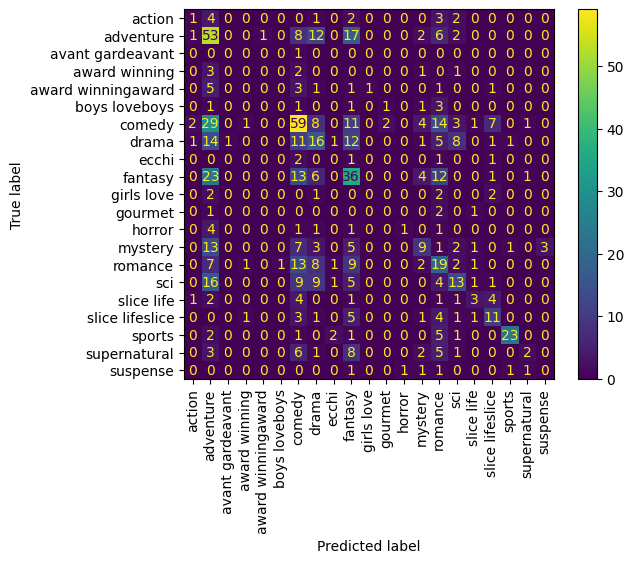

In [477]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred)
plt.xticks(rotation=90)

In [481]:
#! Title	Theme	score	Genre

with open('../WebApp/x_train_svm.pkl','rb') as f:
    X_train_SVM = pickle.load(f)
    

enc.fit_transform(X_train_SVM.to_dict("records"))

text1 = "Son and friends"
text2 = "School"
text3 = "9.03"
text4 = "24"
text5 = "Finished Airing"
text6 = "Spring"
df_temp = pd.DataFrame({'Title': [text1],'Theme': [text2], 'score': [text3], 'Duration':[text4],'Status': [text5],'Premiered': [text6]})
my_svm.predict(enc.transform(df_temp.to_dict("records")))

array(['ecchi'], dtype=object)

In [482]:
import pickle
pickle.dump(my_svm,open('../WebApp/model/SVM.pkl','wb'))